In [1]:
import modules.board_module as bf
import modules.tree_module as tf
import modules.stockfish_module as sf
from ModelSaver import ModelSaver
import random
from dataclasses import dataclass
from collections import namedtuple
import itertools
import time
import argparse
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from math import floor, ceil

# from train_nn_evaluator import EvalDataset

In [2]:
class EvalDataset(torch.utils.data.Dataset):

  def __init__(self, datapath, sample_names, indexes=None, log_level=1):
    """
    Dataset containint stockfish evaluations of chess positions. Pass in the
    path to the samples, their names, and the indexes to load
    """

    t1 = time.time()

    self.modelsaver = ModelSaver(datapath, log_level=log_level)
    self.log_level = log_level
    self.positions = []
    self.seen_values = None

    self.mate_value = 50000             # value of a checkmate (units 1000 per pawn)
    self.convert_evals_to_pawns = True  # convert evaluations from 1000 per pawn, to 1.0 per pawn
    self.use_all_moves = True           # add in all child moves from a positions, instead of the parent
    self.eval_squares = True            # evaluate every square in the board using my handcrafted evaluator
    self.use_eval_normalisation = False # apply normalisation to all evaluations
    self.norm_method = "standard"       # normalisation method to use, standard is mean/std scale -1/+1 bound
    self.norm_factor = None             # normalisation factors saved for future use
    self.board_dtype = torch.float      # datatype to use for torch tensors

    self.boards = []
    self.evals = []

    # automatically get all indexes if not specified
    if indexes is None:
      indexes = list(range(self.modelsaver.get_recent_file(name=sample_names, 
                                                           return_int=True) + 1))

    for ind in indexes:
      newdata = self.modelsaver.load(sample_names, id=ind)
      self.positions += newdata

    t2 = time.time()

    if self.log_level >= 1:
      print(f"EvalDataset(): {len(indexes)} files loaded {t2 - t1:.2f} seconds")

  def __len__(self):
    return len(self.positions)
  
  def __getitem__(self, idx):
    if idx > len(self.positions):
      raise RuntimeError(f"EvalDataset.__getitem__() error: idx ({idx}) > number of samples (len{self.positions})")
    
    return self.positions[idx]
  
  def FEN_to_torch(self, fen_string, move=None, eval_sqs=False):
    """
    Convert an FEN string into a torch tensor board representation
    """

    if move is None:
      boardvec = bf.FEN_to_board_vectors(fen_string)
    else:
      if eval_sqs:
        boardvec = bf.FEN_move_eval_to_board_vectors(fen_string, move)
      else:
        boardvec = bf.FEN_and_move_to_board_vectors(fen_string, move)

    tensortype = self.board_dtype

    t_wP = torch.tensor(boardvec.wP, dtype=tensortype).reshape(8, 8)
    t_wN = torch.tensor(boardvec.wN, dtype=tensortype).reshape(8, 8)
    t_wB = torch.tensor(boardvec.wB, dtype=tensortype).reshape(8, 8)
    t_wR = torch.tensor(boardvec.wR, dtype=tensortype).reshape(8, 8)
    t_wQ = torch.tensor(boardvec.wQ, dtype=tensortype).reshape(8, 8)
    t_wK = torch.tensor(boardvec.wK, dtype=tensortype).reshape(8, 8)
    t_bP = torch.tensor(boardvec.bP, dtype=tensortype).reshape(8, 8)
    t_bN = torch.tensor(boardvec.bN, dtype=tensortype).reshape(8, 8)
    t_bB = torch.tensor(boardvec.bB, dtype=tensortype).reshape(8, 8)
    t_bR = torch.tensor(boardvec.bR, dtype=tensortype).reshape(8, 8)
    t_bQ = torch.tensor(boardvec.bQ, dtype=tensortype).reshape(8, 8)
    t_bK = torch.tensor(boardvec.bK, dtype=tensortype).reshape(8, 8)
    t_wKS = torch.tensor(boardvec.wKS, dtype=tensortype).reshape(8, 8)
    t_wQS = torch.tensor(boardvec.wQS, dtype=tensortype).reshape(8, 8)
    t_bKS = torch.tensor(boardvec.bKS, dtype=tensortype).reshape(8, 8)
    t_bQS = torch.tensor(boardvec.bQS, dtype=tensortype).reshape(8, 8)
    t_colour = torch.tensor(boardvec.colour, dtype=tensortype).reshape(8, 8)

    # ignore these as no data in them currently, just wasted space
    # t_total_moves = torch.tensor(boardvec.total_moves, dtype=tensortype).reshape(8, 8)
    # t_no_take_ply = torch.tensor(boardvec.no_take_ply, dtype=tensortype).reshape(8, 8)

    board_tensor = torch.stack((
      t_wP,
      t_wN,
      t_wB,
      t_wR,
      t_wQ,
      t_wK,
      t_bP,
      t_bN,
      t_bB,
      t_bR,
      t_bQ,
      t_bK,
      t_wKS,
      t_wQS,
      t_bKS,
      t_bQS,
      t_colour,
      # t_total_moves,
      # t_no_take_ply,
    ), dim=0)

    if eval_sqs:
      sq_evals = torch.tensor(boardvec.sq_evals, dtype=float)
      if self.convert_evals_to_pawns:
        sq_evals *= 1e-3
      return board_tensor, sq_evals
    else:
      return board_tensor
  
  def print_board_tensor(self, board_tensor):
    """
    Print the elements of the board tensor
    """

    print("Board tensor shape:", board_tensor.shape)
    print("White pawns", board_tensor[0])
    print("White knights", board_tensor[1])
    print("White bishops", board_tensor[2])
    print("White rooks", board_tensor[3])
    print("White queen", board_tensor[4])
    print("White king", board_tensor[5])
    print("Black pawns", board_tensor[6])
    print("Black knights", board_tensor[7])
    print("Black bishops", board_tensor[8])
    print("Black rooks", board_tensor[9])
    print("Black queen", board_tensor[10])
    print("Black king", board_tensor[11])
    print("White castles KS", board_tensor[12])
    print("White castles QS", board_tensor[13])
    print("Black castles KS", board_tensor[14])
    print("Black castles QS", board_tensor[15])
    print("colour", board_tensor[16])
    print("total moves", board_tensor[17])
    print("no take ply", board_tensor[18])

    return

  def normalise_evaluations(self):
    """
    Normalise the evaluations to zero mean and unit variance, and save the scaling
    """
    if self.norm_method == "minmax":
      max_value = torch.max(-1 * torch.min(self.evals), torch.max(self.evals))
      self.norm_factor = max_value
      self.evals /= self.norm_factor
      if self.log_level > 0:
        print(f"Normalised evaluations, maximum value was {max_value}, now is {torch.max(-1 * torch.min(self.evals), torch.max(self.evals))}")
    
    elif self.norm_method == "standard":
      max_value = torch.max(-1 * torch.min(self.evals), torch.max(self.evals))
      mean = self.evals.mean()
      std = self.evals.std()
      self.evals = (self.evals - mean) / std
      new_max = torch.max(-1 * torch.min(self.evals), torch.max(self.evals))
      self.evals /= new_max
      self.norm_factor = (new_max, mean, std)
      if self.log_level > 0:
        print(f"Normalised evaluations, max_value = {max_value:.3f} (max used = {new_max:.3f}), mean = {mean.item():.3f}, std = {std.item():.3f}, now max value is {torch.max(-1 * torch.min(self.evals), torch.max(self.evals)):.3f}, mean is {self.evals.mean().item():.3f} and std is {self.evals.std().item():.3f}")

  def denomormalise_evaluation(self, value=None, all=False):
    """
    Convert a single value back to regular units (or do it for all saved values)
    """

    if self.norm_method == "minmax":
      if all:
        self.evals *= self.norm_factor
      elif value is not None:
        return value * self.norm_factor
      else:
        raise RuntimeError("EvalDataset.denormalise_evaluations() error: all=False and value=None, incorrect function inputs")
    
    if self.norm_method == "standard":
      if all:
        self.evals = (self.evals * self.norm_factor[0] * self.norm_factor[2]) + self.norm_factor[1]
      elif value is not None:
        return (value * self.norm_factor[0] * self.norm_factor[2]) + self.norm_factor[1]
      else:
        raise RuntimeError("EvalDataset.denormalise_evaluations() error: all=False and value=None, incorrect function inputs")

  def to_torch(self):
    """
    Convert dataset into torch tensors
    """

    t1 = time.time()

    if len(self.positions) == 0:
      print("EvalDataset.to_torch() warning: len(self.positions) == 0, nothing done")
      return

    # get the shape of the board tensors
    example = self.FEN_to_torch(self.positions[0].fen_string)
    num_pos = len(self.positions)

    if self.use_all_moves:
      # count how many positions we will have
      num_lines = 0
      for i in range(num_pos):
        num_lines += len(self.positions[i].move_vector)
      self.boards = torch.zeros((num_lines, *example.shape), dtype=example.dtype)
      self.evals = torch.zeros(num_lines, dtype=torch.float)
      if self.eval_squares:
        self.square_evals = torch.zeros((num_lines, 64), dtype=torch.float)
      add_ind = 0
      error_moves = 0
      if self.log_level > 0:
        print(f"self.use_all_moves = True, found {num_lines} lines (emerging from {num_pos} positions)")
    else:
      self.boards = torch.zeros((num_pos, *example.shape), dtype=example.dtype)
      self.evals = torch.zeros(num_pos, dtype=torch.float)
    
    for i in range(num_pos):

      if self.use_all_moves:
        # loop through all moves and add those boards
        for j in range(len(self.positions[i].move_vector)):
          if self.positions[i].move_vector[j].move_letters == "pv":
            error_moves += 1
            num_lines -= 1
            continue
          if self.eval_squares:
            self.boards[add_ind], self.square_evals[add_ind] = self.FEN_to_torch(
              self.positions[i].fen_string, self.positions[i].move_vector[j].move_letters, self.eval_squares
            )
          else:
            self.boards[add_ind] = self.FEN_to_torch(self.positions[i].fen_string,
                                                    self.positions[i].move_vector[j].move_letters)
          if self.positions[i].move_vector[j].eval == "mate":
            if not bf.is_white_next_FEN(self.positions[i].fen_string):
              self.evals[add_ind] = -self.mate_value
            else:
              self.evals[add_ind] = self.mate_value
          else:
            self.evals[add_ind] = self.positions[i].move_vector[j].eval
          if self.convert_evals_to_pawns:
            self.evals[add_ind] *= 1e-3
          add_ind += 1

      else:
        self.boards[i] = self.FEN_to_torch(self.positions[i].fen_string)
        if self.positions[i].eval == "mate":
          if bf.is_white_next_FEN(self.positions[i].fen_string):
            self.evals[i] = -self.mate_value
          else:
            self.evals[i] = self.mate_value
        else:
          self.evals[i] = self.positions[i].eval
        if self.convert_evals_to_pawns:
          self.evals[i] *= 1e-3

    if self.use_all_moves:
      if error_moves > 0:
        self.boards = self.boards[:num_lines, :, :]
        self.evals = self.evals[:num_lines]
        if self.log_level > 0:
          print(f"The number of error moves was: {error_moves}, out of {num_lines + error_moves} lines. New vector length = {self.evals.shape}")

    # # for testing only
    # print("Shape of self.boards", self.boards.shape)
    # x = num_pos // 2
    # bf.print_FEN_board(self.positions[x].fen_string)
    # self.print_board_tensor(self.boards[x])

    if self.use_eval_normalisation:
      if self.log_level > 0:
        print("EvalDataset() is applying normalisation to self.evals")
      self.normalise_evaluations()

    t2 = time.time()

    if self.log_level > 0:
      if self.use_all_moves:
        total_num = num_lines
      else: total_num = num_pos
      print(f"EvalDataset(): {total_num} positions converted in {t2 - t1:.2f} seconds, average {((t2 - t1) / total_num) * 1e3:.3f} ms per position")

    return
  
  def check_duplicates(self, remove=False, wipe_seen=True):
    """
    Check the number (and potentially remove) duplicates
    """

    t1 = time.time()

    # remove duplicates
    if wipe_seen:
      self.seen_values = set()
    elif self.seen_values is None:
      self.seen_values = set()
      
    unique_positions = []

    for position in self.positions:
      if position.fen_string not in self.seen_values:
        self.seen_values.add(position.fen_string)
        unique_positions.append(position)

    num_duplicates = len(self.positions) - len(unique_positions)

    # now if we want remove the duplicates
    if remove: self.positions = unique_positions

    t2 = time.time()

    if self.log_level >= 1:
      print(f"EvalDataset(): {num_duplicates} duplicates found in {t2 - t1:.2f} seconds{', and removed' if remove else ''}")

    return num_duplicates
  
  def check_mate_positions(self, remove=False):
    """
    Check the number (and potentially remove) mate positions
    """

    t1 = time.time()

    no_mate_positions = []

    # loop backwards over all positions checking for mate
    for i in range(len(self.positions) - 1, -1, -1):
      if self.positions[i].eval != "mate":
        no_mate_positions.append(self.positions[i])

    num_mates = len(self.positions) - len(no_mate_positions)

    # now if we want remove the duplicates
    if remove: self.positions = no_mate_positions

    t2 = time.time()

    if self.log_level >= 1:
      print(f"EvalDataset(): {num_mates} mate positions found in {t2 - t1:.2f} seconds{', and removed' if remove else ''}")

    return num_mates


In [3]:
# load in the entire dataset
num_rand = 4096
datapath = "/home/luke/chess/python/gamedata/samples"
eval_file_template = "random_n={0}_sample"
inds = list(range(1))
log_level = 1
dataset = EvalDataset(datapath, eval_file_template.format(num_rand),
                      indexes=inds, log_level=log_level)

Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_140.lz4 with pickle ... finished
EvalDataset(): 1 files loaded 0.19 seconds


In [4]:
print(f"Total number of positions = {len(dataset)}")
num_duplicates = dataset.check_duplicates()
num_mates = dataset.check_mate_positions()
print(f"Proportion of duplicates = {(num_duplicates / len(dataset))*100:.1f} %")
print(f"Proportion of mate positions = {(num_mates / len(dataset))*100:.1f} %")

# prepare the dataset
print("REMOVING MATES AND DUPLICATES")
num_duplicates = dataset.check_duplicates(remove=True)
num_mates = dataset.check_mate_positions(remove=True)
dataset.board_dtype = torch.float
dataset.to_torch()

Total number of positions = 4096
EvalDataset(): 186 duplicates found in 0.00 seconds
EvalDataset(): 6 mate positions found in 0.00 seconds
Proportion of duplicates = 4.5 %
Proportion of mate positions = 0.1 %
REMOVING MATES AND DUPLICATES
EvalDataset(): 186 duplicates found in 0.00 seconds, and removed
EvalDataset(): 6 mate positions found in 0.00 seconds, and removed
self.use_all_moves = True, found 113778 lines (emerging from 3904 positions)
EvalDataset(): 113778 positions converted in 28.59 seconds, average 0.251 ms per position


In [5]:
savenew = False

if savenew:

  dataset_name = "datasetv2"
  file_name = "data"
  ind_per = 2               # indexes per slice of the dataset
  total_index = 140         # largest index number of gamedata/samples file
  prevent_duplicates = True # prevent duplicates across the entire set, not just in each slice
  savetorchonly = False     # save only the finalised torch tensors
  savetorchtoo = True       # save also a torch version of the dataset
  log_level = 1             # log level during the dataset generation (0=bare minimum, 1=normal)

  num_sets = total_index // ind_per
  if prevent_duplicates: seen_values = set()

  datasaver = ModelSaver("/home/luke/chess/python/datasets/", log_level=log_level)
  datasaver.new_folder(dataset_name)

  for ind in range(num_sets):

    print("Loading set", ind + 1, "/", num_sets)
    indexes = list(range(ind * ind_per + 1, ((ind + 1) * ind_per) + 1))
    dataset = EvalDataset(datapath, eval_file_template.format(num_rand),
                          indexes=indexes, log_level=log_level)
    if prevent_duplicates: dataset.seen_values = seen_values
    num_duplicates = dataset.check_duplicates(remove=True, wipe_seen=not prevent_duplicates)
    num_mates = dataset.check_mate_positions(remove=True)
    dataset.board_dtype = torch.float
    dataset.to_torch()
    if savetorchonly or savetorchtoo:
      if dataset.eval_squares:
        datasaver.save(file_name + "_torch", [dataset.boards, dataset.evals, dataset.square_evals])
      else:
        datasaver.save(file_name + "_torch", [dataset.boards, dataset.evals])
    elif not savetorchonly:
      datasaver.save(file_name, dataset)
    if prevent_duplicates: seen_values = dataset.seen_values

In [6]:
savenew_randomised = False

if savenew_randomised:

  dataset_name = "delete"
  file_name = "data"
  num_per = 200_000         # number of lines per saved file
  total_index = 140         # largest index number of gamedata/samples file
  prevent_duplicates = True # prevent duplicates across the entire set, not just in each slice
  log_level = 1             # log level during the dataset generation (0=bare minimum, 1=normal)

  datasaver = ModelSaver("/home/luke/chess/python/datasets/", log_level=log_level)
  datasaver.new_folder(dataset_name)

  indexes = list(range(1, total_index + 1))
  dataset = EvalDataset(datapath, eval_file_template.format(num_rand),
                          indexes=indexes, log_level=log_level)
  num_duplicates = dataset.check_duplicates(remove=True)
  num_mates = dataset.check_mate_positions(remove=True)
  dataset.to_torch()

  # now randomise a selection of the indexes
  num_boards = len(dataset.evals)
  indexes = list(range(num_boards))
  random.shuffle(indexes)

  num_files = num_boards // num_per
  ind = 0

  print("num_files is", num_files)
  print("num_boards is", num_boards)
  
  for n in range(num_files):

    boards = torch.zeros((num_per, *dataset.boards[0].shape))
    evals = torch.zeros((num_per))
    sq_evals = torch.zeros((num_per, *dataset.square_evals[0].shape))

    for i in range(num_per):

      boards[i] = dataset.boards[indexes[ind]]
      evals[i] = dataset.evals[indexes[ind]]
      sq_evals[i] = dataset.square_evals[indexes[ind]]

      # increment to the next random index
      ind += 1

    datasaver.save(file_name + "_torch", [boards, evals, sq_evals])

In [7]:
def normalise_data(data, factors, clip=None):
  """
  Normalise data based on [max, mean, std]
  """
  max, mean, std = factors
  d = ((data - mean) / std) / max
  if clip is not None:
    d = torch.clip(d, min=-clip, max=clip)
  return d

examine = False

if examine:

  factors = [23.927, -0.240, 0.355]
  factors = [3, -0.240, 0.355]
  norm_evals = normalise_data(dataset.evals, factors, clip=1)

  fig, axs = plt.subplots(1, 1)
  axs.hist(norm_evals.numpy(), bins=50)
  plt.show()

  print(torch.max(dataset.evals))
  print(torch.min(dataset.evals))

In [8]:
class BoardCNN(nn.Module):

  name = "BoardCNN"

  def __init__(self):

    super(BoardCNN, self).__init__()

    self.board_cnn = nn.Sequential(

      # Layer 1
      nn.Conv2d(in_channels=19, out_channels=32, kernel_size=3, padding=1),  # Conv layer
      nn.ReLU(),                                                             # Activation
      nn.MaxPool2d(kernel_size=2),                                           # Pooling (output size: 32 x 4 x 4)

      # Layer 2
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),                                           # Pooling (output size: 64 x 2 x 2)

      # Layer 3
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),                                           # Pooling (output size: 128 x 1 x 1)

      # Flatten layer to transition to fully connected
      nn.Flatten(),

      # two fully connected layers to produce a single output
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 1),
  )

  def forward(self, board):
    board = board.to(self.device)
    x = self.board_cnn(board)
    return x

In [9]:
class ResidualBlock(nn.Module):

  def __init__(self, in_channels, out_channels, stride = 1, downsample = None):

    super(ResidualBlock, self).__init__()
    
    self.conv1 = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
    )
    self.conv2 = nn.Sequential(
      nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
      nn.BatchNorm2d(out_channels)
    )

    self.downsample = downsample
    self.relu = nn.ReLU()
    self.out_channels = out_channels

  def forward(self, x):
    residual = x
    out = self.conv1(x)
    out = self.conv2(out)
    if self.downsample:
      residual = self.downsample(x)
    out += residual
    out = self.relu(out)
    return out
  
class ResNet(nn.Module):

  def __init__(self, block, layers, num_classes = 10):
    super(ResNet, self).__init__()
    self.inplanes = 64
    self.conv1 = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
    self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
    self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
    self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
    self.avgpool = nn.AvgPool2d(7, stride=1)
    self.fc = nn.Linear(512, num_classes)

  def _make_layer(self, block, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes:
      downsample = nn.Sequential(
          nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
          nn.BatchNorm2d(planes),
      )
    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample))
    self.inplanes = planes
    for i in range(1, blocks):
      layers.append(block(self.inplanes, planes))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.layer0(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

class ChessNet(nn.Module):

  def __init__(self, in_channels, num_blocks=3):

    super(ChessNet, self).__init__()

    self.in_channels = in_channels
    c_in = in_channels

    blocks = [ResidualBlock(c_in, c_in) for i in range(num_blocks)]

    self.board_cnn = nn.Sequential(
      *blocks,
      nn.Sequential(nn.Flatten(), nn.Linear(c_in * 8 * 8, c_in), nn.ReLU()),
      nn.Linear(c_in, 1),
    )

  def forward(self, x):
    for l in self.layers:
      x = l(x)
    return x

In [10]:
def train(net, data_x, data_y, epochs=1, lr=5e-5, device="cuda"):
  """
  Perform a training epoch for a given network based on data inputs
  data_x, and correct outputs data_y
  """

  # move onto the specified device
  net.board_cnn.to(device)
  data_x = data_x.to(device)
  data_y = data_y.to(device)

  # put the model in training mode
  net.board_cnn.train()

  lossfcn = nn.MSELoss()
  optim = torch.optim.Adam(net.board_cnn.parameters(), lr=lr)

  batch_size = 64
  num_batches = len(data_x) // batch_size

  for i in range(epochs):

    print(f"Starting epoch {i + 1}. There will be {num_batches} batches")

    rand_idx = torch.randperm(data_x.shape[0])
    avg_loss = 0

    for n in range(num_batches):

      batch_x = data_x[rand_idx[n * batch_size : (n+1) * batch_size]]
      batch_y = data_y[rand_idx[n * batch_size : (n+1) * batch_size]]

      # use the model for a prediction and calculate loss
      net_y = net.board_cnn(batch_x)
      loss = lossfcn(net_y.squeeze(1), batch_y)

      # backpropagate
      loss.backward()
      optim.step()
      optim.zero_grad()

      avg_loss += loss.item()

      # if n % 500 == 0:
      #   print(f"Loss is {(avg_loss / (n + 1)) * 1000:.3f}, epoch {i + 1}, batch {n + 1} / {num_batches}")
    
    print(f"Loss is {(avg_loss / (num_batches * batch_size)) * 1000:.3f}, at end of epoch {i + 1}")

  return net

In [11]:
rexamine = False

if rexamine:

  # load all of the dataset files to examine the data distribution
  max_values = []
  mean_values = []
  std_values = []
  for i in range(1, 11):
    this_data = datasaver.load("datasetv1", id=i)
    this_data.normalise_evaluations()
    max_values.append(this_data.norm_factor[0])
    mean_values.append(this_data.norm_factor[1])
    std_values.append(this_data.norm_factor[2])

  true_max = np.max(max_values)
  avg_mean = np.mean(mean_values)
  avg_std = np.mean(std_values)

  print(f"True max = {true_max:.3f}, true mean = {avg_mean:.3f}, average std = {avg_std:.3f}")

  norm_factors = [true_max, avg_mean, avg_std]

else:
  # True max = 23.927, true mean = -0.240, average std = 0.355
  norm_factors = [23.927, -0.240, 0.355]


In [12]:
def normalise_data(data, factors):
  """
  Normalise data based on [max, mean, std]
  """
  max, mean, std = factors
  return ((data - mean) / std) / max

def denormalise_data(data, factors):
  """
  Undo normalisation based on [max, mean, std]
  """
  max, mean, std = factors
  return (data * max * std) + mean

def train_procedure(net, dataname, dataloader, data_inds, norm_factors,
                    epochs=1, lr=1e-7, device="cuda", batch_size=64,
                    loss_style="MSE"):
  """
  Perform a training epoch for a given network based on data inputs
  data_x, and correct outputs data_y
  """

  # move onto the specified device
  net.board_cnn.to(device)

  # put the model in training mode
  net.board_cnn.train()

  if loss_style.lower() == "mse":
    lossfcn = nn.MSELoss()
  elif loss_style.lower() == "l1":
    lossfcn = nn.L1Loss()
  elif loss_style.lower() == "huber":
    lossfcn = nn.HuberLoss()
  else:
    raise RuntimeError(f"train_procedure() error: loss_style = {loss_style} not recognised")

  optim = torch.optim.Adam(net.board_cnn.parameters(), lr=lr)
  
  # each epoch, cover the entire training dataset
  for i in range(epochs):

    print(f"Starting epoch {i + 1}.")
    total_batches = 0
    epoch_loss = 0

    # load the dataset in a series of slices
    for slice_num, j in enumerate(data_inds):

      # load this segment of the dataset
      dataset = dataloader.load(dataname, id=j)
      data_x = dataset.boards
      data_y = dataset.evals

      # import sys
      # print("The size in bytes of data_x", sys.getsizeof(data_x.storage()))
      # print("The size in bytes of data_y", sys.getsizeof(data_y.storage()))

      # normalise y labels
      data_y = normalise_data(data_y, norm_factors)

      num_batches = len(data_x) // batch_size
      total_batches += num_batches
      rand_idx = torch.randperm(data_x.shape[0])
      avg_loss = 0

      print(f"Starting slice {slice_num + 1} / {len(data_inds)}. There will be {num_batches} batches. ", end="", flush=True)

      # iterate through each batch for this slice of the dataset
      for n in range(num_batches):

        batch_x = data_x[rand_idx[n * batch_size : (n+1) * batch_size]]
        batch_y = data_y[rand_idx[n * batch_size : (n+1) * batch_size]]

        # go to cuda
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # use the model for a prediction and calculate loss
        net_y = net.board_cnn(batch_x)
        loss = lossfcn(net_y.squeeze(1), batch_y)

        # backpropagate
        loss.backward()
        optim.step()
        optim.zero_grad()

        avg_loss += loss.item()

        # if n % 500 == 0:
        #   print(f"Loss is {(avg_loss / (n + 1)) * 1000:.3f}, epoch {i + 1}, batch {n + 1} / {num_batches}")

      # this dataset slice is finished
      epoch_loss += avg_loss
      avg_loss = avg_loss / num_batches
      avg_loss = avg_loss ** 0.5 * norm_factors[0] * norm_factors[2] # try to scale to original units
      print(f"Loss is {avg_loss:.3f}, during epoch {i + 1}, slice {slice_num + 1} / {len(data_inds)}", flush=True)
  
    # this epoch is finished
    epoch_loss = epoch_loss / total_batches
    epoch_loss = epoch_loss ** 0.5 * norm_factors[0] * norm_factors[2] # try to scale to original units
    print(f"Epoch {i + 1} has finished after {total_batches} batches. Overall average loss = {epoch_loss:.3f}", flush=True)

  # finally, return the network that we have trained
  return net

do_train_procedure = False

if do_train_procedure:

  net = ChessNet(19)

  device = "cuda"
  epochs = 10
  data_inds = list(range(1, 11))
  lr = 1e-7

  trained_net = train_procedure(
    net=net,
    dataname="datasetv1",
    dataloader=ModelSaver("/home/luke/chess/python/datasets/", log_level=1),
    data_inds=list(range(1, 11)),
    norm_factors=[23.927, -0.240, 0.355], # [max, mean, std]
    epochs=epochs,
    lr=lr,
    device=device    
  )

In [13]:
test_training = False

if test_training:

  # net = BoardCNN()
  net = ChessNet(19)

  device = "cuda"
  epochs = 10
  lr = 1e-7

  # # normalise the evaluations
  # print(torch.min(dataset.evals))
  # print(torch.max(dataset.evals))
  # dataset.evals /= torch.max(dataset.evals)
  print(torch.min(dataset.evals))
  print(torch.max(dataset.evals))

  trained_net = train(net, dataset.boards, dataset.evals, device=device, epochs=epochs, lr=lr)
  modelsaver = ModelSaver("/home/luke/chess/python/models/")
  modelsaver.save("eval_model", trained_net)

In [40]:
def torch_to_board_vec(tensor):
  """
  Convert a torch board vector into a cpp board vector
  """

  boardvec = bf.BoardVectors()

  boardvec.wP = list(tensor[0].reshape(64))
  boardvec.wN = list(tensor[1].reshape(64))
  boardvec.wB = list(tensor[2].reshape(64))
  boardvec.wR = list(tensor[3].reshape(64))
  boardvec.wQ = list(tensor[4].reshape(64))
  boardvec.wK = list(tensor[5].reshape(64))
  boardvec.bP = list(tensor[6].reshape(64))
  boardvec.bN = list(tensor[7].reshape(64))
  boardvec.bB = list(tensor[8].reshape(64))
  boardvec.bR = list(tensor[9].reshape(64))
  boardvec.bQ = list(tensor[10].reshape(64))
  boardvec.bK = list(tensor[11].reshape(64))
  boardvec.wKS = list(tensor[12].reshape(64))
  boardvec.wQS = list(tensor[13].reshape(64))
  boardvec.bKS = list(tensor[14].reshape(64))
  boardvec.bQS = list(tensor[15].reshape(64))
  boardvec.colour = list(tensor[16].reshape(64))

  return boardvec

loadexisting = True

if loadexisting:

  if False:
    modelloader = ModelSaver("/home/luke/chess/python/models/")
    trained_net = modelloader.load("chessnet_model", id=None)
  else:
    group = "01-11-24"
    run = "run_12-19_A1"
    modelloader = ModelSaver(f"/home/luke/chess/python/models/{group}/{run}")
    trained_net = modelloader.load("network", id=None)
  
  dataset_name = "datasetv3"
  dataset_ind = 65
  dataloader = ModelSaver(f"/home/luke/chess/python/datasets/{dataset_name}")
  boards, evals, sq_evals = dataloader.load("data_torch", id=dataset_ind)

  device = "cpu"
  trained_net.board_cnn.to(device)
  boards = boards.to(device)
  evals = evals.to(device)
  sq_evals = sq_evals.to(device)

  trained_net.board_cnn.eval()

rand = False
inds = list(range(len(evals)))
if rand:
  random.shuffle(inds)

my_diff_vec = []
sf_diff_vec = []

avg_diff_sf = 0
avg_diff_my = 0
n = 1000
inds = inds[:n]
for i in inds:

  # # evaluation comparison
  # sf_eval = dataset.positions[i].eval
  # net_eval = trained_net.board_cnn(dataset.boards[i].to(device).unsqueeze(dim=0))
  # net_eval = net_eval.to("cpu").item()
  # if dataset.use_eval_normalisation:
  #   net_eval = dataset.denomormalise_evaluation(value=net_eval)
  # diff = abs(sf_eval*1e-3 - net_eval)
  # avg_diff += diff
  # if n <= 20:
  #   print(f"sf_eval = {sf_eval * 1e-3:.3f}, net_eval = {net_eval:.3f}, difference is {diff:.3f}")

  # board piece rating comparison
  net_eval = (trained_net.board_cnn(boards[i].unsqueeze(dim=0))).to("cpu")
  net_eval = denormalise_data(net_eval, factors=[7, 0, 2.159])

  this_board_vec = boards[i].to("cpu")
  this_sf_eval = evals[i].to("cpu") * 10
  this_sq_evals = sq_evals[i].to("cpu")

  # board_vec = bf.FEN_to_board_vectors_with_eval(dataset.positions[i].fen_string)
  # board_vec = torch.tensor(board_vec.sq_evals, dtype=torch.float) * 1e-3
  
  net_overall = torch.sum(net_eval)
  true_overall = torch.sum(this_sq_evals)

  net_print = torch.zeros((8, 8))
  true_print = torch.zeros((8, 8))
  
  torch.round(net_eval.reshape(8,8).detach(), decimals=2, out=net_print)
  torch.round(this_sq_evals.reshape(8,8).detach(), decimals=2, out=true_print)

  sf_diff = this_sf_eval - net_overall
  my_diff = true_overall - net_overall

  my_diff_vec.append(my_diff.detach().item())
  sf_diff_vec.append(sf_diff.detach().item())

  avg_diff_sf += abs(sf_diff)
  avg_diff_my += abs(my_diff)
  
  if n <= 50:
    print(f"Case {i + 1} / {n}.", end=" ")
    if n < 6:
      print("Board:")
      bf.print_board_vectors(torch_to_board_vec(this_board_vec))
      # bf.print_FEN_board(dataset.positions[i].fen_string)
      print("Net eval was\n", net_print)
      print("Ground truth was\n", true_print)
    print(f"sf_eval = {this_sf_eval:.3f}, True evaluation = {true_overall:.3f}, net eval = {net_overall:.3f}, difference = {true_overall - net_overall:.3f}")

diff_sf = np.array(sf_diff_vec)
mean_sf_diff = np.mean(np.abs(diff_sf))
std_sf_diff = np.std(diff_sf)

diff_my = np.array(my_diff_vec)
mean_my_diff = np.mean(np.abs(diff_my))
std_my_diff = np.std(diff_my)

print(f"The average difference from {n} samples is u={mean_my_diff:.3f} s={std_my_diff:.3f}, stockfish average difference is u={mean_sf_diff:.3f} s={std_sf_diff:.3f}")

Loading file /home/luke/chess/python/models/01-11-24/run_12-19_A1/network_001.lz4 with pickle ... finished
Loading file /home/luke/chess/python/datasets/datasetv3/data_torch_065.lz4 with pickle ... finished
The average difference from 1000 samples is u=3.416 s=3.866, stockfish average difference is u=2.132 s=2.764


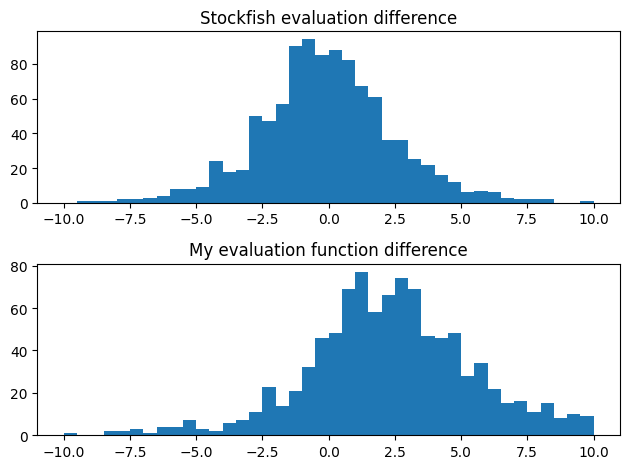

In [39]:
fig, axs = plt.subplots(2, 1)
axs[0].hist(diff_sf, bins=40, range=(-10, 10))
axs[1].hist(diff_my, bins=40, range=(-10, 10))
axs[0].set_title("Stockfish evaluation difference")
axs[1].set_title("My evaluation function difference")
fig.tight_layout()
plt.show()

In [30]:
torch.max(evals)
x = 13
for i in range(len(dataset.positions[x].move_vector)):
  print(f"Move: {dataset.positions[x].move_vector[i].move_letters}, eval = {dataset.positions[x].move_vector[i].eval}")

Move: e1g1, eval = 80
Move: c1e3, eval = 71
Move: h2h4, eval = 70
Move: a4a5, eval = 61
Move: c1g5, eval = 59
Move: e4e5, eval = 59
Move: c1f4, eval = 59
Move: a1b1, eval = 55
Move: d1c2, eval = 36
Move: c4b3, eval = 31
Move: h2h3, eval = 29
Move: c1d2, eval = 26
Move: e2g3, eval = 18
Move: a1a2, eval = 18
Move: a1a3, eval = 14
Move: c4a2, eval = 10
Move: b2b3, eval = 10
Move: c4b5, eval = 9
Move: e1f2, eval = 5
Move: d1d3, eval = 5
Move: b2b4, eval = 3
Move: d1b3, eval = 2
Move: e2f4, eval = -1
Move: c3b5, eval = -1
Move: d1d2, eval = -1
Move: c4d3, eval = -10
Move: g2g4, eval = -19
Move: g2g3, eval = -24
Move: h1f1, eval = -32
Move: c3a2, eval = -38
Move: e1f1, eval = -39
Move: c3b1, eval = -55
Move: e2g1, eval = -56
Move: d4d5, eval = -59
Move: h1g1, eval = -65
Move: e1d2, eval = -169
Move: c4d5, eval = -234
Move: f3f4, eval = -252
Move: c3d5, eval = -261
Move: c4f7, eval = -335
Move: c4e6, eval = -366
Move: c1h6, eval = -391
Move: c4a6, eval = -507


In [31]:
time_net = True

if time_net:

  timedevice = "cuda"
  trained_net.board_cnn.eval()
  trained_net.board_cnn.to(timedevice)
  num = 1000
  j = 0

  t1 = time.process_time()
  for i in range(num):
    trained_net.board_cnn(dataset.boards[j].to(timedevice).unsqueeze(dim=0))
    j += 1
    if j >= len(dataset.boards):
      j = 0
  t2 = time.process_time()

  print(f"Network: Total time {t2 - t1:.1f}s, so {((t2 - t1) / num) * 1e3:.3f} ms per evaluation")

  t1 = time.process_time()
  for i in range(num):
    bf.generate_moves_FEN(dataset.positions[j].fen_string)
    j += 1
    if j >= len(dataset.boards):
      j = 0
  t2 = time.process_time()

  print(f"Handcrafted: Total time {t2 - t1:.1f}s, so {((t2 - t1) / num) * 1e3:.3f} ms per evaluation")

Network: Total time 10.6s, so 10.566 ms per evaluation
Handcrafted: Total time 0.5s, so 0.478 ms per evaluation


In [32]:
extend_training = False

if extend_training:

  more_epochs = 10
  new_lr = 1e-8
  trained_net = train(trained_net, dataset.boards, dataset.evals, device=device, epochs=more_epochs, lr=new_lr)
  modelsaver = ModelSaver("/home/luke/chess/python/models/")
  modelsaver.save("eval_model", trained_net)